## RNN Network

In [1]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf  # Version 1.0.0 (some previous versions are used in past commits)

from sklearn import metrics

import os

### Useful Constants

In [2]:
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 


### Downloading the data: 

In [3]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells

DATA_PATH = '/home/siddiqmk/Tutorials/'

!pwd && ls
os.chdir(DATA_PATH)
!pwd && ls

!python download_dataset.py

!pwd && ls
os.chdir("..")
!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)


/home/siddiqmk/HAR/RNNv01
data	 LSTM_files  README.md	RNNv02.ipynb
LICENSE  LSTM.ipynb  RNN.ipynb	time_series.ipynb
/home/siddiqmk/Tutorials
 Basic-LRP   LRP-Time-Series  'UCI HAR Dataset'
 LICENSE     README.md	       Visual-Explanation-of-Atari
python: can't open file 'download_dataset.py': [Errno 2] No such file or directory
/home/siddiqmk/Tutorials
 Basic-LRP   LRP-Time-Series  'UCI HAR Dataset'
 LICENSE     README.md	       Visual-Explanation-of-Atari
/home/siddiqmk
Cardio		   HAR				    physionet.org
cardio		   HEY_HAR			    Physionet_Project
dataset_repair	   LSTM-Human-Activity-Recognition  test1.ipynb
dlime_experiments  PhysioNet2020		    Tutorials
ECG_analysis	   PhysioNet_MRH_June12		    zhuc

Dataset is now located at: /home/siddiqmk/Tutorials/UCI HAR Dataset/


In [4]:
TRAIN = "train/"
TEST = "test/"

# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    
    # Reading through the signal file to cycle through all the train or test file.
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

#initiating load function for train and test 
X_train = load_X(X_train_signals_paths) 
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


In [5]:
type(y_test)
y_test.shape

(2947, 1)

### Training and Test Parameters

In [6]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep,


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")
#print(X_test)
print(n_steps)
print(n_input)

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.
128
9


### Training Functions

In [7]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    print('_X:',_X)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    print('_X transposed:',_X)
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    print('_X reshaped:',_X)
    
    # ReLU activation, thanks to Yu Zhao for adding this improvement here:
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

        #NO LONGER FUNCTIONAL - KEPT FOR NOTEKEEPING PURPOSES
    ## Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    #lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    #lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    #lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    ## Get LSTM cell output
    #outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow 
    # The new classes as the ones above are deprecated
    lstm_cell_1 = tf.nn.rnn_cell.LSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.nn.rnn_cell.LSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.nn.static_rnn(lstm_cells, _X, dtype=tf.float32) # modified from original version finally works.
    #outputs, states = tf.keras.layers.RNN(lstm_cells, _X, dtype=tf.float32) #using modified notaiton - won't work
    #outputs, states = tf.keras.layers.RNN(lstm_cells, _X, dtype=tf.float32)
    
    # Get last time step's output feature for a "many-to-one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_, n_classes=n_classes):
    # Function to encode neural one-hot output labels from number indexes 
    # e.g.: 
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

### Building the RNN

In [8]:
tf.compat.v1.disable_eager_execution() # an attempt to get rid of the placeholder not working with eager execution enabled

# Graph input/output

###original functions
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
print('x_shape',x.shape)
y = tf.placeholder(tf.float32, [None, n_classes])
print('y_shape',y.shape)
###modiefied to work with eager execution enabled - currently seems to work by simply removing "placeholder"
#x = str([None, n_steps, n_input])
#print (x.shape)
#y = str([None, n_classes])


# Graph weights (tf.random_normal was the old version, now it's tf.random.normal)
weights = {
    'hidden': tf.Variable(tf.random.normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random.normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random.normal([n_hidden])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)


# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


x_shape (None, 128, 9)
y_shape (None, 6)
_X: Tensor("Placeholder:0", shape=(None, 128, 9), dtype=float32)
_X transposed: Tensor("transpose:0", shape=(128, None, 9), dtype=float32)
_X reshaped: Tensor("Reshape:0", shape=(None, 9), dtype=float32)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


### Train Neural Network

In [9]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:2 -> device: XLA_GPU device

Training iter #1500:   Batch Loss = 3.371246, Accuracy = 0.1653333306312561
PERFORMANCE ON TEST SET: Batch Loss = 2.815948724746704, Accuracy = 0.18255853652954102
Training iter #30000:   Batch Loss = 1.369404, Accuracy = 0.699999988079071
PERFORMANCE ON TEST SET: Batch Loss = 1.4358043670654297, Accuracy = 0.646080732345581
Training iter #60000:   Batch Loss = 1.104061, Accuracy = 0.781333327293396
PERFORMANCE ON TEST SET: Batch Loss = 1.2716457843780518, Accuracy = 0.7315914630889893
Training iter #90000:   Batch Loss = 1.020422, Accuracy = 0.8386666774749756
PERFORMANCE ON TEST SET: Batch Loss = 1.2030613422393799, Accuracy = 0.7757040858268738
Training iter #120000:   Ba

<ipython-input-12-ad20a0a07b33>:27: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc='bottom right', shadow=True)


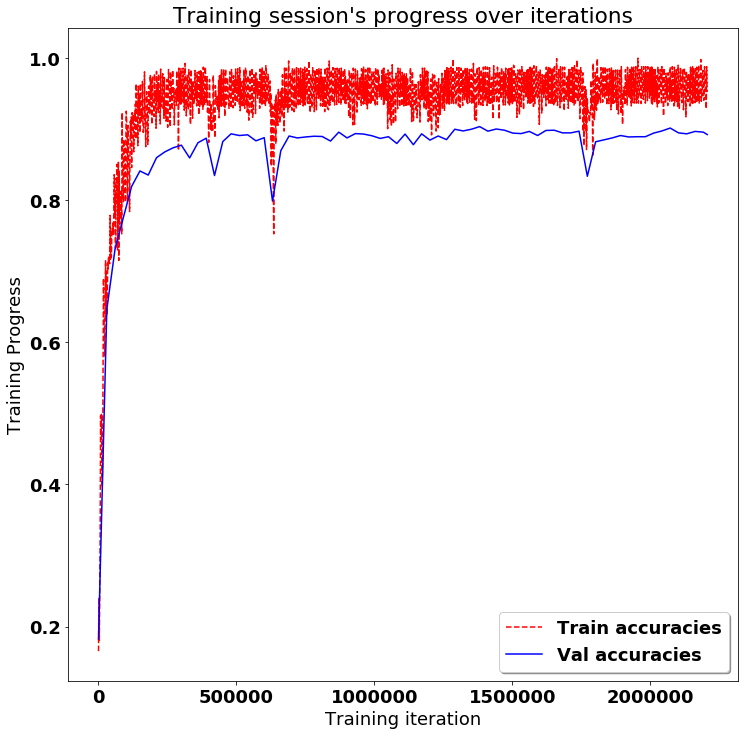

In [12]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "r--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", label="Val accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='bottom right', shadow=True)
plt.ylabel('Training Progress')
plt.xlabel('Training iteration')

plt.show()

### Confusion Matrix

Testing Accuracy: 89.07363414764404%

Precision: 89.57483316614899%
Recall: 89.07363420427554%
f1_score: 89.09219391211002%

Confusion Matrix:
[[447   1  48   0   0   0]
 [ 13 422  36   0   0   0]
 [  0   2 418   0   0   0]
 [  0   8   0 417  66   0]
 [  3   0   0 128 401   0]
 [  0  17   0   0   0 520]]

Confusion matrix (normalised to % of total test data):
[[15.167968    0.03393281  1.628775    0.          0.          0.        ]
 [ 0.44112659 14.319647    1.2215812   0.          0.          0.        ]
 [ 0.          0.06786563 14.183916    0.          0.          0.        ]
 [ 0.          0.2714625   0.         14.149983    2.2395658   0.        ]
 [ 0.10179844  0.          0.          4.3434     13.607058    0.        ]
 [ 0.          0.5768578   0.          0.          0.         17.645063  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


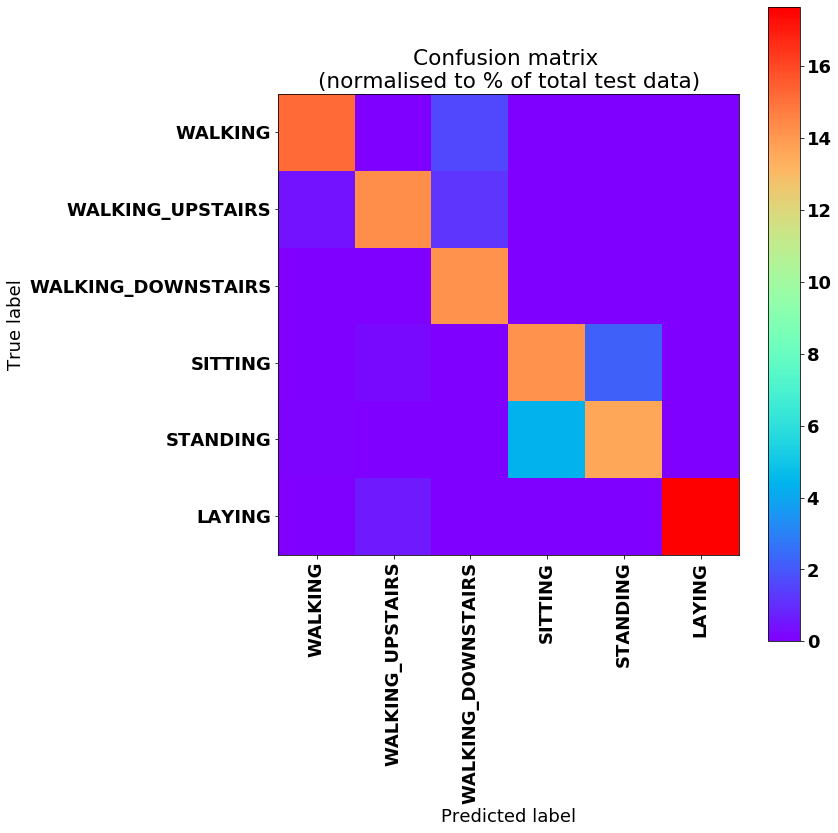

In [11]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
pred.summary()

AttributeError: 'Tensor' object has no attribute 'summary'

In [12]:
sess.summary()

AttributeError: 'InteractiveSession' object has no attribute 'summary'

### Trying out LRP on the RNN

In [15]:
conv_ksize = 2
pool_ksize = 2
conv_strides = 1
pool_strides = 2

weights.reverse()
activations.reverse()

AttributeError: 'dict' object has no attribute 'reverse'

In [16]:
print(pred)

Tensor("add_3:0", shape=(None, 6), dtype=float32)


In [19]:
print(weights)

{'hidden': <tf.Variable 'Variable_12:0' shape=(9, 32) dtype=float32>, 'out': <tf.Variable 'Variable_13:0' shape=(32, 6) dtype=float32>}


In [21]:
LSTM_RNN.summary()

AttributeError: 'function' object has no attribute 'summary'

In [22]:
pred.reverse()

AttributeError: 'Tensor' object has no attribute 'reverse'

In [13]:
weights

{'hidden': <tf.Variable 'Variable:0' shape=(9, 32) dtype=float32>,
 'out': <tf.Variable 'Variable_1:0' shape=(32, 6) dtype=float32>}

In [23]:
weights2 = weights

In [24]:
weights2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*kernel.*')

In [25]:
weights2

[<tf.Variable 'rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0' shape=(64, 128) dtype=float32>,
 <tf.Variable 'rnn/multi_rnn_cell/cell_1/lstm_cell/kernel:0' shape=(64, 128) dtype=float32>]

In [26]:
weights.reverse()

AttributeError: 'dict' object has no attribute 'reverse'

In [25]:
biases = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*bias.*')

In [14]:
biases

{'hidden': <tf.Variable 'Variable_2:0' shape=(32,) dtype=float32>,
 'out': <tf.Variable 'Variable_3:0' shape=(6,) dtype=float32>}

In [12]:
x

<tf.Tensor 'Placeholder:0' shape=(None, 128, 9) dtype=float32>

In [17]:
x.reverse()

AttributeError: 'Tensor' object has no attribute 'reverse'

In [19]:
act = x

In [20]:
act

<tf.Tensor 'Placeholder:0' shape=(None, 128, 9) dtype=float32>

In [ ]:
act = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*bias.*')

In [21]:
activations = tf.get_collection('DTD')

In [22]:
X = activations[0]

IndexError: list index out of range

In [28]:
x

<tf.Tensor 'Placeholder:0' shape=(None, 128, 9) dtype=float32>